# initialize the workspace

## import relevant packages

In [1]:
# import packages
import numpy as np
import cv2
from skimage.measure import label, regionprops
from skimage import img_as_ubyte
import tifffile
import matplotlib.pyplot as plt

## import the test image
+ display it

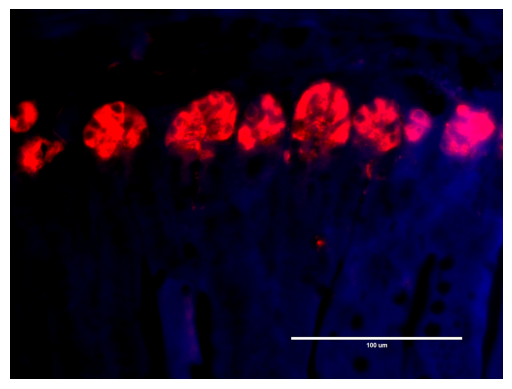

In [2]:
# class
class BlobDetector:
    def __init__(self, image_path):
        self.image_path = image_path
        self.raw_image = tifffile.imread(image_path)
        self.current_image = self.raw_image.copy()
        self.bar_mask = None
        self.binary_mask = None
        self.cleaned_mask = None
        self.blob_props = None
    def display(self, img=None):
        if img is None:
            img = self.current_image
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
# init class
image_path = "G2EB-RFP 40x-4.tif"
detector = BlobDetector(image_path)
detector.display()


# image preparation and processing

## prep class

In [3]:
class image_prep:
    class inconvenient_object_remover:
        def __init__(self, raw_image):
            self.raw_image = raw_image
        def remove_scale_bar(self, intensity_threshold=240, min_area=500, aspect_ratio_thresh=4.0):
            img = self.raw_image
            if img.ndim == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            else:
                gray = img.copy()
    
            _, binary = cv2.threshold(gray, intensity_threshold, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
            mask = np.ones_like(gray, dtype=np.uint8)
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                area = cv2.contourArea(cnt)
                aspect_ratio = max(w / h, h / w)
                if area > min_area and aspect_ratio > aspect_ratio_thresh:
                    cv2.rectangle(mask, (x, y), (x + w, y + h), 0, -1)
    
            self.bar_mask = mask
            if img.ndim == 3:
                self.current_image = cv2.merge([
                    cv2.bitwise_and(img[:, :, c], img[:, :, c], mask=mask)
                    for c in range(img.shape[2])
                ])
            else:
                self.current_image = cv2.bitwise_and(img, img, mask=mask)
            return self.current_image
    class select_image_channels:
        @staticmethod
        def red(img):
            
            if img.ndim == 3:
                current_image = img[:, :, 0]
            else:
                current_image = img.copy()
            return current_image
        @staticmethod
        def red_chromaticity(img):
            if img.ndim != 3:
                raise ValueError("Red chromaticity requires an RGB image.")
            R = img[:, :, 0].astype(float)
            G = img[:, :, 1].astype(float)
            B = img[:, :, 2].astype(float)
    
            epsilon = 1e-8  # Avoid division by zero
            sum_rgb = R + G + B + epsilon
            red_chroma = R / sum_rgb
    
            return (red_chroma * 255).astype(np.uint8)  # Scale back to 0-255 for image-like display
    class enhance_contrast:
        @staticmethod
        def CLAHE(img, clip_limit=2.0, tile_grid_size=(8,8)):
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
            img_8bit = img_as_ubyte(img / img.max())  # Normalize to 8-bit
            return clahe.apply(img_8bit)
        @staticmethod
        def enhance_nonblack(img, value=255):
            """
            Set all non-zero pixels in a grayscale image to a fixed value.
            Black (0) pixels remain black.

            Parameters:
            - img: Grayscale image as numpy array.
            - value: Brightness value to set (default 255).

            Returns:
            - Enhanced image.
            """
            # Ensure image is a numpy array
            img = np.asarray(img)

            # Create output array
            enhanced = np.zeros_like(img, dtype=np.uint8)

            # Set non-zero pixels to 'value'
            enhanced[img > 0] = value

            return enhanced
    class masker:            
        def __init__(self, image):
            self.current_image = image
        def otsu(self):
            _, binary = cv2.threshold(self.current_image, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            self.binary_mask = binary
            return self
        def morph_cleanup(self, kernel_size=5):
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
            cleaned = cv2.morphologyEx(self.binary_mask, cv2.MORPH_OPEN, kernel)
            cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
            self.cleaned_mask = cleaned
            return self
        
            
    

## remove scale bar

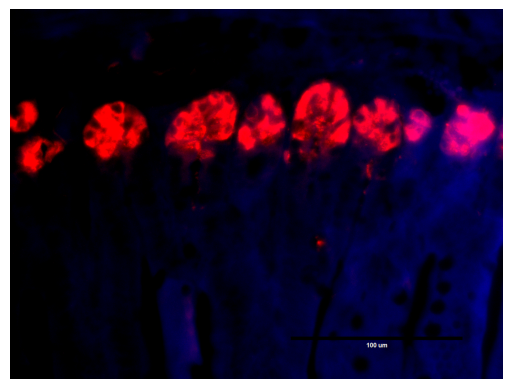

In [4]:
inconvenient_object_remover = image_prep.inconvenient_object_remover
detector.current_image = inconvenient_object_remover(detector.current_image).remove_scale_bar()
detector.display()

## select red chanel
this is bc the lysozyme stains fit nicely within the red channel, also removes the blue background

In [5]:
detector.red_chr_image = image_prep.select_image_channels.red_chromaticity(detector.current_image)
detector.red_image = image_prep.select_image_channels.red(detector.current_image)

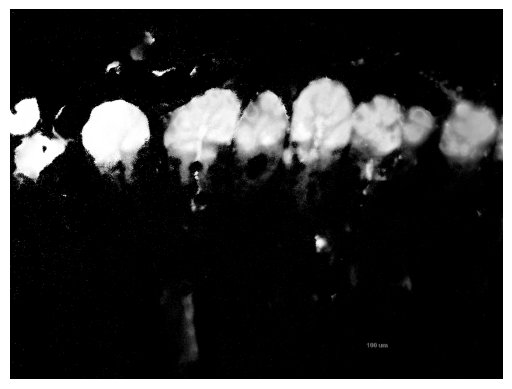

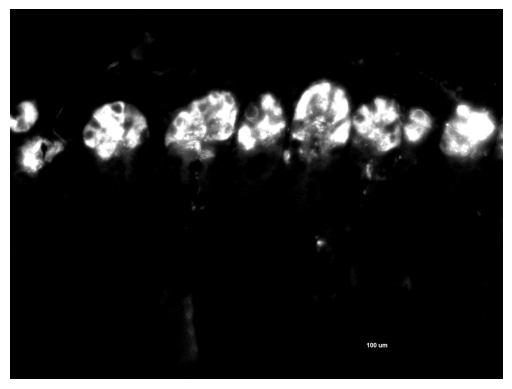

In [6]:
detector.display(img=detector.red_chr_image)
detector.display(img=detector.red_image)

## apply CLAHE


### what is clahe

CLAHE stands for Contrast Limited Adaptive Histogram Equalization.

Let’s break that down:

Histogram Equalization is a method for adjusting image contrast by redistributing pixel intensities so they use the full available dynamic range (from black to white). It’s like stretching the histogram to make dark regions darker and bright regions brighter.

Adaptive means that instead of applying the same adjustment everywhere, CLAHE works in small regions of the image (called tiles or grid cells). This is important for images where brightness and contrast vary across different parts.

Contrast Limited means it avoids making the contrast too extreme in areas where the histogram is very concentrated (like in noisy regions). Without this, adaptive methods can produce weird artifacts like bright spots or speckles.

🎯 Why Do We Need CLAHE in the Code?
Your images (e.g., red channel from a tissue stain) might have:

Uneven lighting.

Varying contrast across different regions.

Faint signals in some areas that you want to enhance.

Simply applying a global contrast adjustment (like cv2.equalizeHist) might:

Overexpose bright regions.

Leave dark regions unchanged.

CLAHE helps by:
✅ Boosting contrast locally within each tile.
✅ Preserving details in both bright and dark regions.
✅ Reducing the risk of amplifying noise in homogeneous areas.

This makes it easier to detect blobs (your regions of interest) by:

Enhancing the signal where the stain is faint.

Making sure contrast is improved everywhere, not just globally.

### code

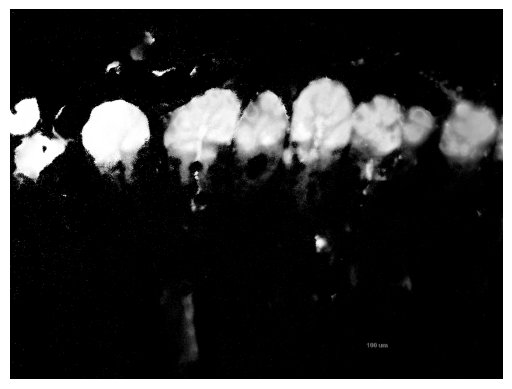

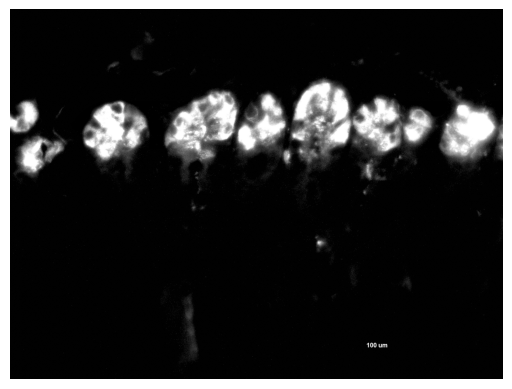

In [7]:
detector.red_chr_image_enhanced = image_prep.enhance_contrast.enhance_nonblack(detector.red_chr_image)
detector.red_image = image_prep.enhance_contrast.CLAHE(detector.red_image)
detector.display(detector.red_chr_image)
detector.display(img=detector.red_image)
    

## binary mask
the goal of this is to create a binary mask that cleanly captures the boundries of the stained lysozyme regions

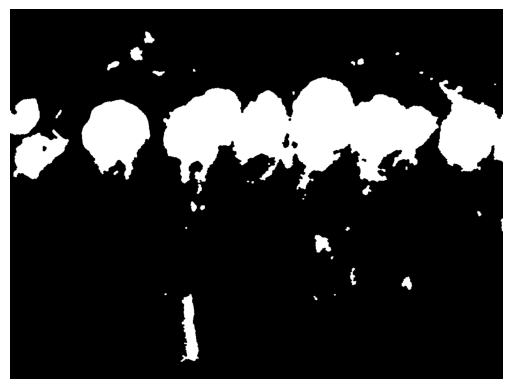

In [8]:
detector.chr_binary_mask = image_prep.masker(detector.red_chr_image_enhanced).otsu().morph_cleanup().cleaned_mask
plt.imshow(detector.chr_binary_mask, cmap='gray')
plt.axis('off')
plt.show()



# extract blobs
following the image processing creating a representative binary map, we will use said binary map to identify broader boundries of the things

## blob handler class

## demonstrate blob detections solution

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, segmentation, color, measure
from scipy import ndimage as ndi

class BlobDetector:
    class region_based_segmentation:
        def __init__(self, image, low_thresh=10, high_thresh=150):
            self.image = image
            self.low_thresh = low_thresh
            self.high_thresh = high_thresh

            self.elevation_map = None
            self.markers = None
            self.segmentation = None
            self.labeled = None
            self.label_overlay = None

        def detect_blobs(self):
            # 1️⃣ Compute elevation map
            self.elevation_map = filters.sobel(self.image)

            # 2️⃣ Generate markers
            self.markers = np.zeros_like(self.image, dtype=np.uint8)
            self.markers[self.image < self.low_thresh] = 1
            self.markers[self.image > self.high_thresh] = 2

            # 3️⃣ Watershed segmentation
            self.segmentation = segmentation.watershed(self.elevation_map, self.markers)
            self.segmentation = ndi.binary_fill_holes(self.segmentation - 1)

            # 4️⃣ Label blobs
            self.labeled, _ = ndi.label(self.segmentation)

            # 5️⃣ Create label overlay
            self.label_overlay = color.label2rgb(self.labeled, image=self.image, bg_label=0)
            return self
        def show_results(self):
            if self.elevation_map is None:
                raise RuntimeError("Run detect_blobs() first!")

            fig, axes = plt.subplots(2, 3, figsize=(12, 6))
            
            # Original image
            axes[0, 0].imshow(self.image, cmap='gray')
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')

            # Elevation map
            axes[0, 1].imshow(self.elevation_map, cmap='gray')
            axes[0, 1].set_title('Elevation Map')
            axes[0, 1].axis('off')

            # Markers
            axes[0, 2].imshow(self.markers, cmap='nipy_spectral')
            axes[0, 2].set_title('Markers')
            axes[0, 2].axis('off')

            # Segmentation
            axes[1, 0].imshow(self.segmentation, cmap='gray')
            axes[1, 0].set_title('Segmentation Mask')
            axes[1, 0].axis('off')

            # Labeled blobs
            axes[1, 1].imshow(self.label_overlay)
            axes[1, 1].set_title('Label Overlay')
            axes[1, 1].axis('off')

            # Segmentation overlay on original
            axes[1, 2].imshow(self.image, cmap='gray')
            axes[1, 2].contour(self.segmentation, [0.5], linewidths=1.2, colors='y')
            axes[1, 2].set_title('Segmentation Overlay')
            axes[1, 2].axis('off')

            fig.tight_layout()
            plt.show()
            

        

## implement blob detection using region-based segmentation

## code explainations

### self.blob_props
🧭 What is self.blob_props?
✅ It’s a list of regionprops objects from skimage.measure.regionprops.
✅ Each object in the list represents one detected blob (a connected region of non-zero pixels in your binary mask).
✅ These blobs are sorted by area (largest first) and limited to the top N blobs (default: 5).

🎯 How Does It Get Created?
Here’s the flow:

```
self.label_img = label(self.binary_mask)  # Labels connected components in the mask
props = regionprops(self.label_img)       # Extracts blob properties for each labeled region
self.blob_props = sorted(props, key=lambda x: x.area, reverse=True)[:top_n]
```
📦 What’s Inside Each Blob (regionprops object)?
Each blob object in self.blob_props contains rich information about the detected blob.
For example, each blob has:

| Attribute      | Meaning                                                  | Example                       |
| -------------- | -------------------------------------------------------- | ----------------------------- |
| `area`         | Number of pixels in the blob                             | 1203                          |
| `bbox`         | Bounding box (min\_row, min\_col, max\_row, max\_col)    | (45, 100, 150, 210)           |
| `centroid`     | Center coordinates (row, col)                            | (97.5, 155.2)                 |
| `coords`       | List of pixel coordinates                                | Array of shape (N, 2)         |
| `eccentricity` | How elongated the blob is                                | 0.85                          |
| `perimeter`    | Blob perimeter                                           | 145.3                         |
| `intensity_*`  | If using `intensity_image`, mean/centroid intensity etc. | (with `current_image` passed) |


✅ You can access these like:

python
Copy
Edit
for blob in self.blob_props:
    print(blob.area, blob.centroid, blob.eccentricity)
🧠 In Plain Language
✅ self.blob_props is your list of detected blobs.
✅ Each blob is a region object with properties like:

Size (area)

Location (centroid, bounding box)

Shape (eccentricity, perimeter)

Pixel coordinates (coords)

✅ It’s like having a spreadsheet of blob measurements you can use for analysis or drawing.

## blob implementation

### first identify the blobs

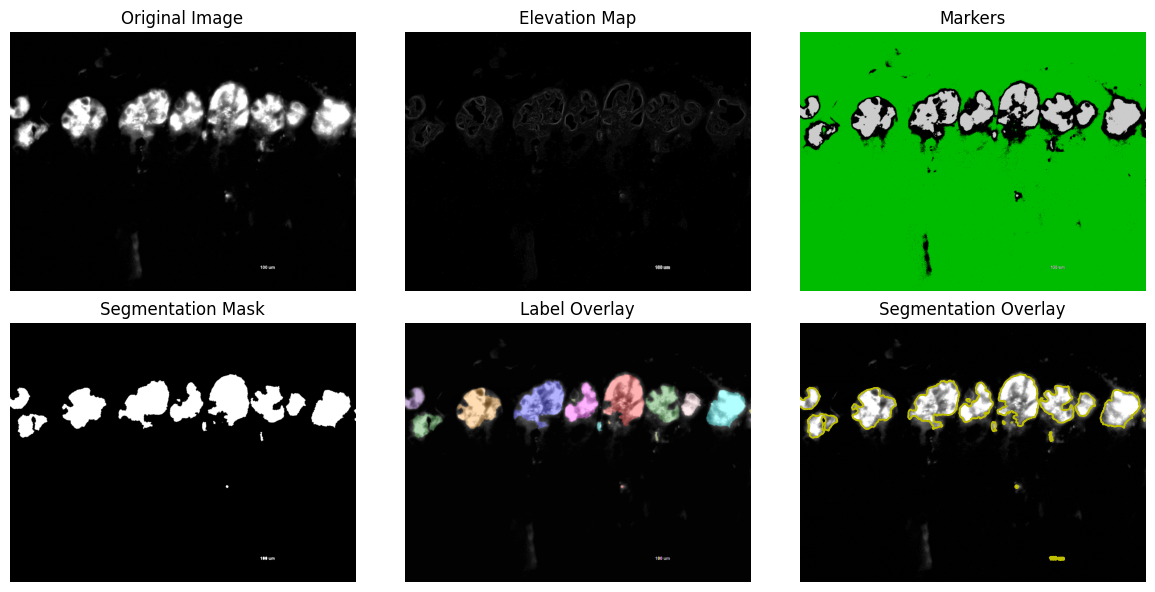

In [10]:
blob_detector = BlobDetector.region_based_segmentation(detector.red_image, low_thresh=30, high_thresh=150)
blob_detector.detect_blobs().show_results()

### second define the real boundries of each blob

🧠 Swallowing Logic: Rule Definition
For each pair of adjacent regions in the expanded mask:

If Region A and Region B touch:

And Area(B) < (1/20) × Area(A) (based on original pre-expansion area from tight labels):

Region A absorbs Region B (relabel B’s pixels as A).

If neither is larger by that margin, leave both unchanged.

C:\Users\phsil\AppData\Local\Temp\ipykernel_47060\524529128.py:42: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  dilated = dilation(mask, square(3))
C:\Users\phsil\AppData\Local\Temp\ipykernel_47060\524529128.py:78: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  dilated = dilation(mask, square(3))


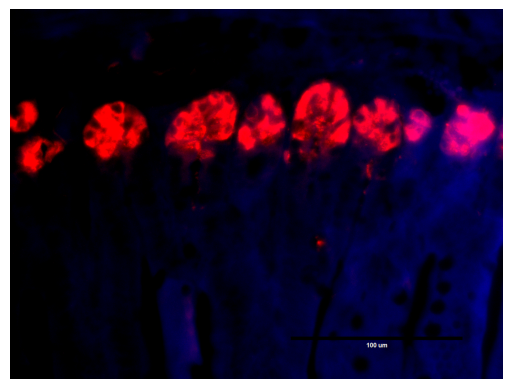

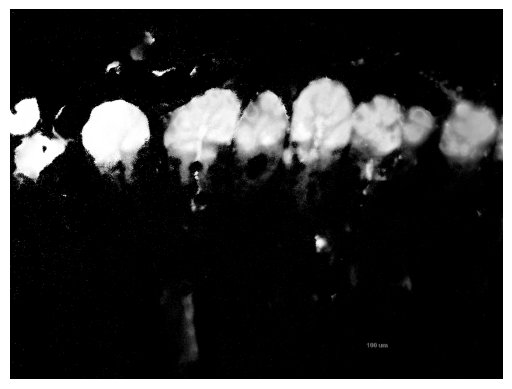

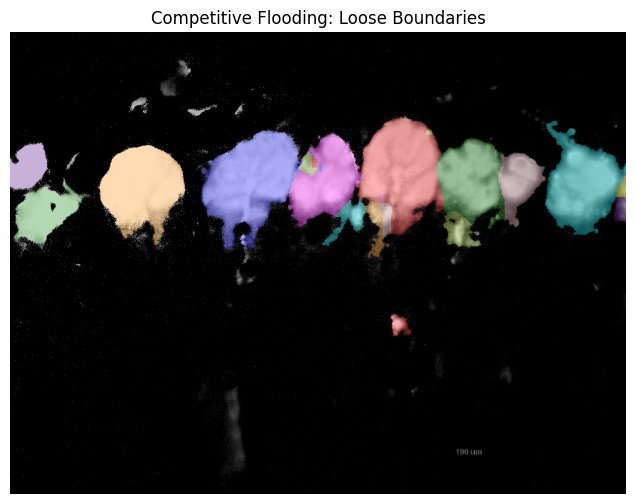

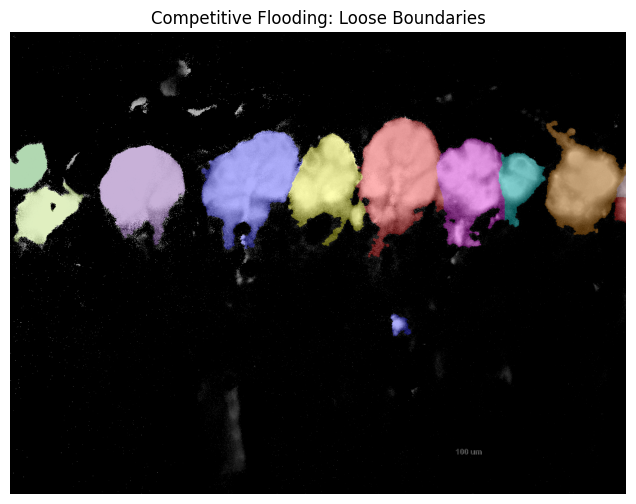

In [15]:
from skimage import measure
import numpy as np
from skimage.segmentation import flood
from skimage.segmentation import watershed
# Assuming blob_detector.labeled is the labeled tight blobs
tight_labels = blob_detector.labeled
loose_mask = detector.chr_binary_mask  # Use the binary mask from the red chromaticity image

loose_boundaries = {}
for region in measure.regionprops(blob_detector.labeled):
    centroid = tuple(map(int, region.centroid))
    loose_region = flood(loose_mask, seed_point=centroid)
    loose_boundaries[region.label] = loose_region


# tight_labels = your labeled tight blobs
# loose_mask = your loose binary mask (True/False)

# Use the tight labels as markers
markers = tight_labels.copy()

# Run watershed using loose mask as constraint
# Use a flat surface (or 1 - loose mask) as "terrain"
terrain = np.ones_like(loose_mask, dtype=np.uint8)  # flat terrain

# Or you could use the original image for intensity-based flooding:
# terrain = -filtered_image

# Run watershed
expanded_labels = watershed(terrain, markers=markers, mask=loose_mask)

from skimage.morphology import dilation, square
from skimage.segmentation import find_boundaries

# expanded_labels = final expanded labels after watershed

adjacency = {}
for label in np.unique(expanded_labels):
    if label == 0:
        continue
    mask = expanded_labels == label
    dilated = dilation(mask, square(3))
    neighbors = np.unique(expanded_labels[dilated])
    neighbors = [n for n in neighbors if n != label and n != 0]
    adjacency[label] = neighbors

swallowed_labels = expanded_labels.copy()

from skimage import measure

# Dictionary to store area for each label
original_areas = {}

# Get region properties from the tight labels
for region in measure.regionprops(tight_labels):
    original_areas[region.label] = region.area

def get_border_labels(label_image):
    border_mask = np.zeros_like(label_image, dtype=bool)
    border_mask[0, :] = True
    border_mask[-1, :] = True
    border_mask[:, 0] = True
    border_mask[:, -1] = True

    border_labels = np.unique(label_image[border_mask])
    border_labels = border_labels[border_labels != 0]  # Exclude background

    return set(border_labels)

adjacency = {}  # Filtered adjacency list with size check
border_lengths = {}  # Store border lengths for small blob-neighbor pairs
border_labels = get_border_labels(expanded_labels)
for label in np.unique(expanded_labels):
    if label == 0:
        continue
    area_label = original_areas[label]
    mask = (expanded_labels == label)
    dilated = dilation(mask, square(3))
    neighbors = np.unique(expanded_labels[dilated])
    neighbors = [n for n in neighbors if n != label and n != 0]
    
    eligible_neighbors = []
    for neighbor in neighbors:
        area_neighbor = original_areas.get(neighbor, 0)
        if area_neighbor >= area_label * 20:
            eligible_neighbors.append(neighbor)
            
            # Compute border overlap
            shared_border = np.logical_and(dilated, expanded_labels == neighbor)
            border_length = np.sum(shared_border)
            border_lengths[(label, neighbor)] = border_length

    if eligible_neighbors:
        adjacency[label] = eligible_neighbors

# Now pick the best neighbor for each small blob
swallow_plan = {}
for label, neighbors in adjacency.items():
    if label in border_labels:
        continue  # Skip border-touching blobs
    # Find the neighbor with the largest border overlap
    best_neighbor = max(neighbors, key=lambda n: (border_lengths[(label, n)], original_areas[n]))
    swallow_plan[label] = best_neighbor

# Apply swallowing
swallowed_labels = expanded_labels.copy()
for small, big in swallow_plan.items():
    swallowed_labels[swallowed_labels == small] = big



# Visualize
from skimage.color import label2rgb
expanded = label2rgb(expanded_labels, image=detector.red_chr_image, bg_label=0)
overlay = label2rgb(swallowed_labels, image=detector.red_chr_image, bg_label=0)

detector.display()
detector.display(img=detector.red_chr_image)
plt.figure(figsize=(8, 6))
plt.imshow(expanded)
plt.title("Competitive Flooding: Loose Boundaries")
plt.axis('off')
plt.show()
plt.figure(figsize=(8, 6))
plt.imshow(overlay)
plt.title("Competitive Flooding: Loose Boundaries")
plt.axis('off')
plt.show()

    
    



#### get something usefull out of it

In [ ]:


from skimage import measure

# final_labels = your label image after swallowing
final_labels = swallowed_labels
# Compute region properties
props = measure.regionprops(final_labels)

# Sort by area (descending)
sorted_props = sorted(props, key=lambda r: r.area, reverse=True)

# Get top 5 blobs
top_blobs = sorted_props[:5]

# Get their labels
top_labels = [region.label for region in top_blobs]
print("Top 5 blob labels:", top_labels)

# Dictionary: {label: mask}
blob_masks = {}

for region in top_blobs:
    mask = (final_labels == region.label)
    blob_masks[region.label] = mask
    
    
blob_intensity_data = {}

for label, mask in blob_masks.items():
    intensity_region = detector.red_image * mask
    blob_intensity_data[label] = intensity_region

    # Example: Compute stats
    intensities = detector.red_image[mask]
    mean_intensity = intensities.mean()
    max_intensity = intensities.max()
    min_intensity = intensities.min()
    print(f"Blob {label}: Mean={mean_intensity:.2f}, Max={max_intensity}, Min={min_intensity}")



Top 5 blob labels: [1, 2, 7, 8, 5]
